In [98]:
# Create a new conda environment with the following command:
# conda create -n bench python=3 pandas seaborn matplotlib numpy
# conda activate bench

import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams

import pandas as pd
import seaborn as sns


In [99]:

figure_save = True
figure_fmt = 'pdf'
path_suffix = '-baseline'
# path_suffix = '-best_mr_copy'

rcParams.update({'figure.autolayout': True})


In [100]:
# problem_size,dims,kernel,tool,accel_size,accel_version,strategy,threads,board,REST OF PERF OUT,filename
# file_path='../results/results-tul-Fri_31_Mar_2023_03:26:42_PM_UTC.csv'
file_path = '../results/results-tul-2023_04_03-01:27:15-UTC-baseline.csv'
# file_path = '../results/results-tul-2023_04_03-00:22:42-UTC-best_mr_copy.csv'
# file_path = '../results/results-latest.csv'

# read file into rows
rows = []
with open(file_path, 'r') as f:
    for line in f:
        rows.append(line.split(','))


df = pd.DataFrame.from_records(rows)
df.head()

# only keep columns from A to L
df = df.iloc[:, 0:12]

# drop column 10
df = df.drop(columns=[10])
df.head()


df.columns = ['problem_size', 'dims', 'kernel', 'tool', 'accel_size',
              'accel_version', 'strategy', 'threads', 'board', 'value', 'metric']
df.head()

# make accel_size an int
df['accel_size'] = df['accel_size'].astype(int)

# problem_size has a string of three values that are always the same
# split problem size and assign it to dims column
df['dims'] = df['problem_size'].str.split('_').str[0]
df['dims'] = df['dims'].astype(int)

# make value a float, using toNumeric
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# drop problem_size column
df = df.drop(columns=['problem_size'])
# drop threads column
df = df.drop(columns=['threads'])

all_columns = df.columns


def filter_df(df, filter_dict):
    """Filter the df based on dictionary key pairs"""
    # now implement the filter [(df['metric'] == 'task-clock') & (df['strategy'] == 'Ns') & ...]
    filter = []
    for key, value in filter_dict.items():
        filter.append(df[key] == value)
    # filter is a list of boolean arrays
    # use the & operator to combine them
    filter = np.array(filter).all(axis=0)
    # apply the filter
    return df[filter]


# show the unique values in the accel_size, accel_version, and strategy columns
print(df['accel_size'].unique())
print(df['accel_version'].unique())
print(df['strategy'].unique())
print(df['tool'].unique())
print(df['board'].unique())
print(df['metric'].unique())

df.head()


[ 4  8 16  0]
['v2' 'v1' 'v3' 'NONE']
['As' 'Ns' 'Bs' 'Cs' 'NONE']
['mlir_ACC' 'cpp_MAN' 'mlir_CPU']
['tul_rel']
['branch-instructions' 'branch-misses' 'cache-references' 'cache-misses'
 'cpu-cycles' 'context-switches' 'page-faults' 'task-clock'
 'L1-dcache-load-misses' 'L1-dcache-loads' 'L1-dcache-stores'
 'L1-icache-load-misses' 'duration_time']


,dims,kernel,tool,accel_size,accel_version,strategy,board,value,metric
0,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,14467824.0,branch-instructions
1,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,2051981.0,branch-misses
2,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,85726312.0,cache-references
3,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,375875.0,cache-misses
4,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,313476587.0,cpu-cycles


In [101]:
def update_legend_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    for i, label in enumerate(labels):
        label = label.replace('value, ', '')
        label = label.replace(')', '')
        label = label.replace('(', '')

        # Some mapping
        label = label.replace('mlir_ACC', 'mlir_AXI4MLIR')
        label = label.replace('mlir_CPU', 'mlir_CPU')
        label = label.replace('cpp_MAN',  'cpp_MANUAL')
        labels[i] = label

    # edit labels in legend
    ax.legend(handles, labels)
    return handles, labels


# Filter the data based on dictionary and plot

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'strategy', 'board', 'metric']
pv_columns:	['tool']
to_plot:	['value']
len of df_pivot: 51
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
dropping metric          unique value is: Index(['task-clock'], dtype='object', name='metric') 


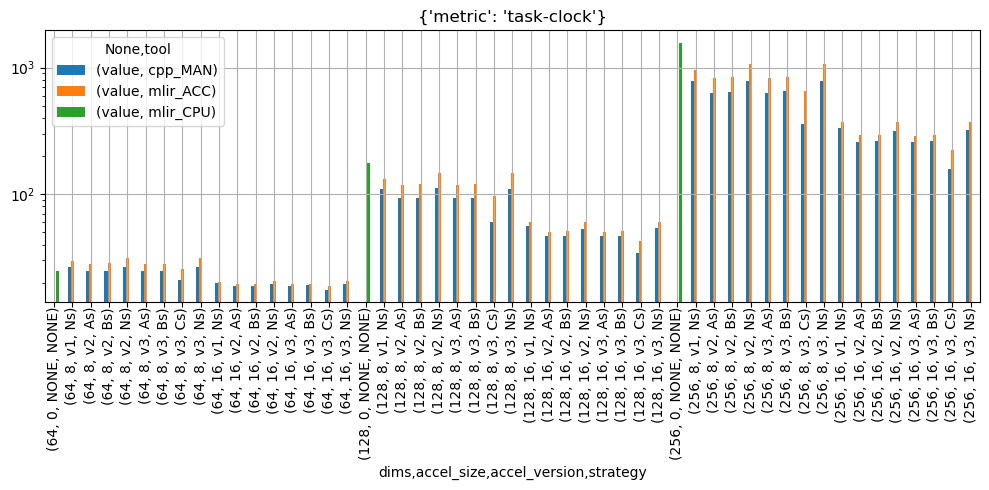

In [102]:
# filter_dict = {'metric': 'task-clock',
#                 'accel_version': 'v3',
#                 'dims': 128}
# filter_dict = {'metric': 'task-clock',
#                 'strategy': 'Ns',
#                 'dims': 128}
filter_dict = {}
filter_dict['metric'] = 'task-clock'
# filter_dict['metric'] = 'cache-references'
# filter_dict['metric'] = 'branch-instructions'
# filter_dict['metric'] = 'branch-misses'
# filter_dict['metric'] = 'page-faults'

# filter_dict['strategy'] = 'NA'
# filter_dict['strategy'] = 'Ns'
# filter_dict['accel_size'] = 16
# filter_dict['tool'] = 'cpp_MAN'

# filter_dict['accel_version'] = 'v3'
# filter_dict['dims'] = 16
# filter_dict['dims'] = 64
# filter_dict['dims'] = 128
# filter_dict['dims'] = 256

filtered_df = filter_df(df, filter_dict)

# remove tool that is mlir_ACC
# filtered_df = filtered_df[filtered_df.tool != 'mlir_ACC']

# filter out accel_type v1
# filtered_df = filtered_df[filtered_df.accel_version != 'v1']

# filter any accel_size simaller than 4
# filtered_df = filtered_df[filtered_df.accel_size >= 8]

# filter, accept accel_size different than 4
filtered_df = filtered_df[filtered_df.accel_size != 4]

# filter any dims simaller than 64
filtered_df = filtered_df[filtered_df.dims >= 64]

# filter out tool cpp_MAN that is not strategy Ns
# positive_filter = (filtered_df['tool'] == 'cpp_MAN') & (
#     filtered_df['strategy'] != 'Ns')
# filtered_df = filtered_df[~positive_filter]


# remove everything that is not strategy Ns and NA
# filtered_df = filtered_df[(filtered_df['strategy'] == 'Ns') | (
#     filtered_df['strategy'] == 'NONE')]

to_plot = ['value']
# pv_columns = ['strategy', 'tool']
pv_columns = ['tool']
# pv_columns = ['accel_version']
# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=(10, 5), logy=True)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
# ax.set_yticks([10000, 100000])

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
# y ticks
# add grid
ax.grid()
plt.title(filter_dict)
# plt.savefig('sine_waves.pdf', format='pdf')
plt.show()


# Characterization

## plot-characterization-logsacle

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'strategy', 'board', 'metric']
pv_columns:	['tool']
to_plot:	['value']
len of df_pivot: 20
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping strategy        unique value is: Index(['Ns'], dtype='object', name='strategy') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
dropping metric          unique value is: Index(['task-clock'], dtype='object', name='metric') 
filter_dict: {'metric': 'task-clock'}


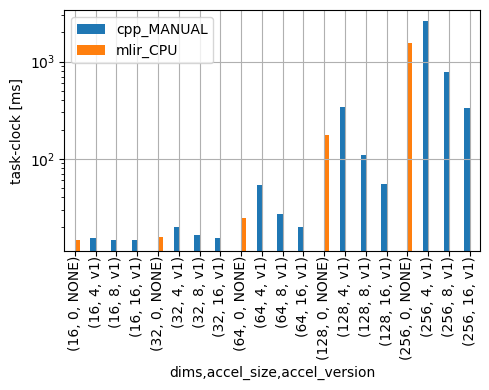

In [103]:
# Edit the following variables to change the plot

experiment = 'plot-characterization-logsacle'
logy = True
y_label = 'task-clock [ms]'
x_label_rotation = False
title = ''
figure_size = (5, 4)

# What to plot
to_plot = ['value']
# pv_columns = ['strategy', 'tool']
pv_columns = ['tool']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
filter_dict['metric'] = 'task-clock'

filtered_df = filter_df(df, filter_dict)

# remove tool that is mlir_ACC
filtered_df = filtered_df[filtered_df.tool != 'mlir_ACC']

# remove everything that is not v1 or NONE
filtered_df = filtered_df[(filtered_df['accel_version'] == 'v1') | (
    filtered_df['strategy'] == 'NONE')]


# remove everything that is not strategy Ns and NA
filtered_df = filtered_df[(filtered_df['strategy'] == 'Ns') | (
    filtered_df['strategy'] == 'NONE')]

# rename all strategy NONE to NA
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'NONE': 'Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=figure_size, logy=True)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
# ax.set_yticks([10000, 100000])

update_legend_labels(ax)

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
# y ticks
# add grid
ax.grid()
print('filter_dict: {}'.format(filter_dict))
plt.title(title)
plt.ylabel(y_label)
if (x_label_rotation):
    plt.xticks(rotation=0, ha='center')
if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


## plot-characterization-dim-128

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'strategy', 'board', 'metric']
pv_columns:	['tool']
to_plot:	['value']
len of df_pivot: 4
dropping dims            unique value is: Int64Index([128], dtype='int64', name='dims') 
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping strategy        unique value is: Index(['Ns'], dtype='object', name='strategy') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
dropping metric          unique value is: Index(['task-clock'], dtype='object', name='metric') 
filter_dict: {'metric': 'task-clock', 'dims': 128}


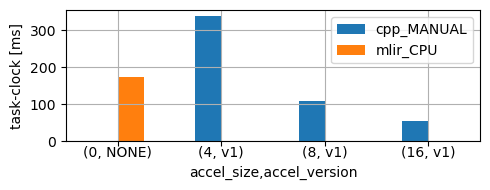

In [104]:
# Edit the following variables to change the plot

experiment = 'plot-characterization-dims-128'
logy = False
y_label = 'task-clock [ms]'
x_label_rotation = True
title = ''
figure_size = (5, 2)

# What to plot
to_plot = ['value']
# pv_columns = ['strategy', 'tool']
pv_columns = ['tool']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
filter_dict['metric'] = 'task-clock'
filter_dict['dims'] = 128

filtered_df = filter_df(df, filter_dict)


# remove tool that is mlir_ACC
filtered_df = filtered_df[filtered_df.tool != 'mlir_ACC']

# remove everything that is not v1 or NONE
filtered_df = filtered_df[(filtered_df['accel_version'] == 'v1') | (
    filtered_df['strategy'] == 'NONE')]


# remove everything that is not strategy Ns and NA
filtered_df = filtered_df[(filtered_df['strategy'] == 'Ns') | (
    filtered_df['strategy'] == 'NONE')]

# rename all strategy NONE to NA
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'NONE': 'Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=figure_size, logy=logy)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
# ax.set_yticks([10000, 100000])

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
# y ticks
# add grid
update_legend_labels(ax)
ax.grid()
print('filter_dict: {}'.format(filter_dict))
plt.title(title)
plt.ylabel(y_label)
if (x_label_rotation):
    plt.xticks(rotation=0, ha='center')
if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


# Experiments

## Nothing stationary vs all - cpp_MAN vs mlir_ACC

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'board', 'metric']
pv_columns:	['tool', 'strategy']
to_plot:	['value']
len of df_pivot: 12
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
dropping metric          unique value is: Index(['task-clock'], dtype='object', name='metric') 
filter_dict: {'metric': 'task-clock'}


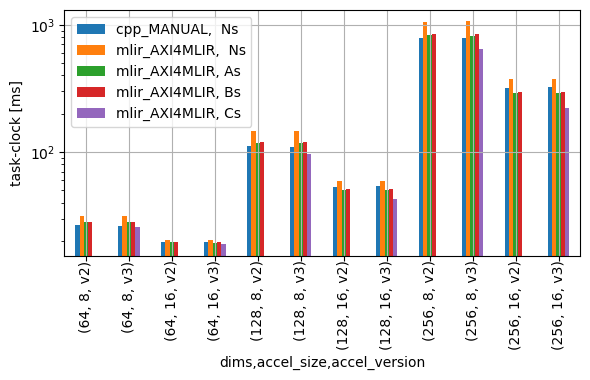

In [105]:
# Edit the following variables to change the plot

experiment = 'plot-manual-vs-mlir-genereated-all-ns-vs-all-logscale'
logy = True
y_label = 'task-clock [ms]'
x_label_rotation = False
title = ''
figure_size = (6, 3.9)

# What to plot
# to_plot = ['value']
pv_columns = ['strategy', 'tool']
pv_columns = ['tool', 'strategy']
# pv_columns = ['strategy']
# pv_columns = ['tool']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
filter_dict['metric'] = 'task-clock'
# filter_dict['dims'] = 128

filtered_df = filter_df(df, filter_dict)

# remove mlir_CPU
filtered_df = filtered_df[filtered_df.tool != 'mlir_CPU']

# remove v1
filtered_df = filtered_df[filtered_df.accel_version != 'v1']

# filter, accept accel_size different than 4
filtered_df = filtered_df[filtered_df.accel_size != 4]

# filter any dims simaller than 64
filtered_df = filtered_df[filtered_df.dims >= 64]

# filter out tool cpp_MAN that is not strategy Ns
positive_filter = (filtered_df['tool'] == 'cpp_MAN') & (
    filtered_df['strategy'] != 'Ns')
filtered_df = filtered_df[~positive_filter]

# rename all strategy Ns to ' Ns'
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'Ns': ' Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=figure_size, logy=logy)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
# ax.set_yticks([10000, 100000])

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
# y ticks
# add grid
update_legend_labels(ax)
ax.grid()
print('filter_dict: {}'.format(filter_dict))
plt.title(title)
plt.ylabel(y_label)
if (x_label_rotation):
    plt.xticks(rotation=0, ha='center')
if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


## Ns Vs Optimized flows

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'board', 'metric']
pv_columns:	['tool', 'strategy']
to_plot:	['value']
len of df_pivot: 4
dropping dims            unique value is: Int64Index([128], dtype='int64', name='dims') 
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
dropping metric          unique value is: Index(['task-clock'], dtype='object', name='metric') 
filter_dict: {'metric': 'task-clock', 'dims': 128}


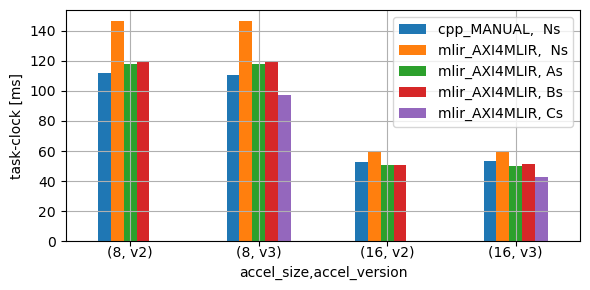

In [106]:
# Edit the following variables to change the plot

experiment = 'plot-manual-vs-mlir-genereated-128-ns-vs-all'
logy = False
y_label = 'task-clock [ms]'
x_label_rotation = True
title = ''
figure_size = (6, 3)

# What to plot
# to_plot = ['value']
pv_columns = ['strategy', 'tool']
pv_columns = ['tool', 'strategy']
# pv_columns = ['strategy']
# pv_columns = ['tool']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
filter_dict['metric'] = 'task-clock'
filter_dict['dims'] = 128

filtered_df = filter_df(df, filter_dict)

# remove mlir_CPU
filtered_df = filtered_df[filtered_df.tool != 'mlir_CPU']

# remove v1
filtered_df = filtered_df[filtered_df.accel_version != 'v1']

# filter, accept accel_size different than 4
filtered_df = filtered_df[filtered_df.accel_size != 4]

# filter any dims simaller than 64
filtered_df = filtered_df[filtered_df.dims >= 64]

# filter out tool cpp_MAN that is not strategy Ns
positive_filter = (filtered_df['tool'] == 'cpp_MAN') & (
    filtered_df['strategy'] != 'Ns')
filtered_df = filtered_df[~positive_filter]

# rename all strategy Ns to ' Ns'
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'Ns': ' Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=figure_size, logy=logy)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
# ax.set_yticks([10000, 100000])

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
# y ticks
update_legend_labels(ax)
# add grid
ax.grid()
print('filter_dict: {}'.format(filter_dict))
plt.title(title)
plt.ylabel(y_label)

if (x_label_rotation):
    plt.xticks(rotation=0, ha='center')
if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


## Normalized metrics

In [107]:
# Prepare for normalization
all_columns = df.columns
columns_to_pivot = ['metric']
values_to_pivot = ['value']
# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in columns_to_pivot + values_to_pivot]
df_p = df.pivot(index=pv_index, columns=columns_to_pivot,
                values=values_to_pivot[0])
df_p = df_p.reset_index()

# Normalize all values based on row mlir_CPU, accel_size=0, accel_version=NONE, strategy=NONE, dims=<dims_value>
# columns to normalize: c
c = df['metric'].unique()

for d in df_p['dims'].unique():
    cpu_loc = (df_p['tool'] == 'mlir_CPU') & (df_p['dims'] == d)
    acc_loc = (df_p['tool'] == 'mlir_ACC') & (df_p['dims'] == d)
    man_loc = (df_p['tool'] == 'cpp_MAN') & (df_p['dims'] == d)

    # assert count of True values in cpu_loc is 1
    assert sum(cpu_loc) == 1

    # Normalize accelerator values by CPU values, then normalize CPU values by CPU values
    df_p.loc[acc_loc, c] = df_p.loc[acc_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[man_loc, c] = df_p.loc[man_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[cpu_loc, c] = df_p.loc[cpu_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)

df_n = df_p
df_n.head()

# Transform df_n that has one metric per column to df_n2 that has one metric per row
df_n2 = df_n.melt(id_vars=pv_index, value_vars=c,
                  var_name='metric', value_name='value')
df_n2.head()


,dims,kernel,tool,accel_size,accel_version,strategy,board,metric,value
0,16,matmul_i32,cpp_MAN,4,v1,Ns,tul_rel,branch-instructions,0.955843
1,16,matmul_i32,cpp_MAN,4,v2,As,tul_rel,branch-instructions,0.955575
2,16,matmul_i32,cpp_MAN,4,v2,Bs,tul_rel,branch-instructions,0.990898
3,16,matmul_i32,cpp_MAN,4,v2,Ns,tul_rel,branch-instructions,0.975545
4,16,matmul_i32,cpp_MAN,4,v3,As,tul_rel,branch-instructions,0.947435


In [108]:
df.metric.unique()


array(['branch-instructions', 'branch-misses', 'cache-references',
       'cache-misses', 'cpu-cycles', 'context-switches', 'page-faults',
       'task-clock', 'L1-dcache-load-misses', 'L1-dcache-loads',
       'L1-dcache-stores', 'L1-icache-load-misses', 'duration_time'],
      dtype=object)

### Cache references and Branch instructions

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'board', 'metric']
pv_columns:	['tool', 'strategy']
to_plot:	['value']
len of df_pivot: 3
dropping dims            unique value is: Int64Index([128], dtype='int64', name='dims') 
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping accel_size      unique value is: Int64Index([16], dtype='int64', name='accel_size') 
dropping accel_version   unique value is: Index(['v3'], dtype='object', name='accel_version') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
filter_dict: {'accel_version': 'v3', 'dims': 128, 'accel_size': 16}


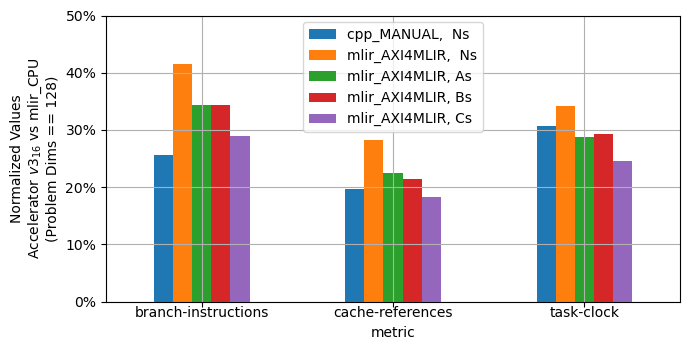

In [109]:
# Edit the following variables to change the plot

experiment = 'plot-manual-vs-mlir-flows-128-16-counters-limited'
logy = False
y_label = 'Normalized Values\nAccelerator $v3_{16}$ vs mlir_CPU\n(Problem Dims == 128)'
x_label_rotation = True
title = ''
figure_size = (7, 3.6)


# What to plot
to_plot = ['value']
# pv_columns = ['strategy', 'tool']
pv_columns = ['tool', 'strategy']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
# filter_dict['metric'] = 'task-clock'
filter_dict['accel_version'] = 'v3'
filter_dict['dims'] = 128
filter_dict['accel_size'] = 16

filtered_df = filter_df(df_n2, filter_dict)

# only include the following tools metrics

# options: ['branch-instructions', 'branch-misses', 'cache-references',
#    'cache-misses', 'cpu-cycles', 'context-switches', 'page-faults',
#    'task-clock', 'L1-dcache-load-misses', 'L1-dcache-loads',
#    'L1-dcache-stores', 'L1-icache-load-misses', 'duration_time']

# keep task-clock, l1-dcache-loads, l1-dcache-stores,cache-references,cache-misses
filtered_df = filtered_df[filtered_df.metric.isin(
    ['task-clock', 'cache-references', 'branch-instructions'])]


# remove mlir_CPU
filtered_df = filtered_df[filtered_df.tool != 'mlir_CPU']

# remove v1
filtered_df = filtered_df[filtered_df.accel_version != 'v1']

# # filter, accept accel_size different than 4
# filtered_df = filtered_df[filtered_df.accel_size != 4]

# # filter any dims simaller than 64
# filtered_df = filtered_df[filtered_df.dims >= 64]

# filter out tool cpp_MAN that is not strategy Ns
positive_filter = (filtered_df['tool'] == 'cpp_MAN') & (
    filtered_df['strategy'] != 'Ns')
filtered_df = filtered_df[~positive_filter]

# rename all strategy Ns to ' Ns'
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'Ns': ' Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=figure_size, logy=logy)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
# ax.set_yticks([10000, 100000])

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
# y ticks
# legend to top middle
handles, labels = update_legend_labels(ax)
ax.legend(handles, labels, loc='upper center')
# add grid
ax.grid()
print('filter_dict: {}'.format(filter_dict))
plt.title(title)
plt.ylabel(y_label)
# Limit y axis to 0.0 to 0.5
plt.ylim(0.0, 0.5)
# Transform axis to percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

if (x_label_rotation):
    plt.xticks(rotation=0, ha='center')
if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


# Optmized Results

In [110]:

figure_save = True
figure_fmt = 'pdf'
# path_suffix = '-baseline'
path_suffix = '-best_mr_copy'

rcParams.update({'figure.autolayout': True})

# problem_size,dims,kernel,tool,accel_size,accel_version,strategy,threads,board,REST OF PERF OUT,filename
# file_path='../results/results-tul-Fri_31_Mar_2023_03:26:42_PM_UTC.csv'
# file_path = '../results/results-tul-2023_04_03-01:27:15-UTC-baseline.csv'
file_path = '../results/results-tul-2023_04_03-00:22:42-UTC-best_mr_copy.csv'
# file_path = '../results/results-latest.csv'

# read file into rows
rows = []
with open(file_path, 'r') as f:
    for line in f:
        rows.append(line.split(','))


df = pd.DataFrame.from_records(rows)
df.head()

# only keep columns from A to L
df = df.iloc[:, 0:12]

# drop column 10
df = df.drop(columns=[10])
df.head()


df.columns = ['problem_size', 'dims', 'kernel', 'tool', 'accel_size',
              'accel_version', 'strategy', 'threads', 'board', 'value', 'metric']
df.head()

# make accel_size an int
df['accel_size'] = df['accel_size'].astype(int)

# problem_size has a string of three values that are always the same
# split problem size and assign it to dims column
df['dims'] = df['problem_size'].str.split('_').str[0]
df['dims'] = df['dims'].astype(int)

# make value a float, using toNumeric
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# drop problem_size column
df = df.drop(columns=['problem_size'])
# drop threads column
df = df.drop(columns=['threads'])

all_columns = df.columns


def filter_df(df, filter_dict):
    """Filter the df based on dictionary key pairs"""
    # now implement the filter [(df['metric'] == 'task-clock') & (df['strategy'] == 'Ns') & ...]
    filter = []
    for key, value in filter_dict.items():
        filter.append(df[key] == value)
    # filter is a list of boolean arrays
    # use the & operator to combine them
    filter = np.array(filter).all(axis=0)
    # apply the filter
    return df[filter]


# show the unique values in the accel_size, accel_version, and strategy columns
print(df['accel_size'].unique())
print(df['accel_version'].unique())
print(df['strategy'].unique())
print(df['tool'].unique())
print(df['board'].unique())
print(df['metric'].unique())

df.head()


[ 4  8 16  0]
['v2' 'v1' 'v3' 'NONE']
['As' 'Ns' 'Bs' 'Cs' 'NONE']
['mlir_ACC' 'cpp_MAN' 'mlir_CPU']
['tul_rel']
['branch-instructions' 'branch-misses' 'cache-references' 'cache-misses'
 'cpu-cycles' 'context-switches' 'page-faults' 'task-clock'
 'L1-dcache-load-misses' 'L1-dcache-loads' 'L1-dcache-stores'
 'L1-icache-load-misses' 'duration_time']


,dims,kernel,tool,accel_size,accel_version,strategy,board,value,metric
0,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,13547556.0,branch-instructions
1,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,1841700.0,branch-misses
2,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,62331926.0,cache-references
3,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,389680.0,cache-misses
4,128,matmul_i32,mlir_ACC,4,v2,As,tul_rel,273710346.0,cpu-cycles


## Normalized data

In [111]:
# Prepare for normalization
all_columns = df.columns
columns_to_pivot = ['metric']
values_to_pivot = ['value']
# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in columns_to_pivot + values_to_pivot]
df_p = df.pivot(index=pv_index, columns=columns_to_pivot,
                values=values_to_pivot[0])
df_p = df_p.reset_index()

# Normalize all values based on row mlir_CPU, accel_size=0, accel_version=NONE, strategy=NONE, dims=<dims_value>
# columns to normalize: c
c = df['metric'].unique()

for d in df_p['dims'].unique():
    cpu_loc = (df_p['tool'] == 'mlir_CPU') & (df_p['dims'] == d)
    acc_loc = (df_p['tool'] == 'mlir_ACC') & (df_p['dims'] == d)
    man_loc = (df_p['tool'] == 'cpp_MAN') & (df_p['dims'] == d)

    # assert count of True values in cpu_loc is 1
    assert sum(cpu_loc) == 1

    # Normalize accelerator values by CPU values, then normalize CPU values by CPU values
    df_p.loc[acc_loc, c] = df_p.loc[acc_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[man_loc, c] = df_p.loc[man_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[cpu_loc, c] = df_p.loc[cpu_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)

df_n = df_p
df_n.head()

# Transform df_n that has one metric per column to df_n2 that has one metric per row
df_n2 = df_n.melt(id_vars=pv_index, value_vars=c,
                  var_name='metric', value_name='value')
df_n2.head()


,dims,kernel,tool,accel_size,accel_version,strategy,board,metric,value
0,16,matmul_i32,cpp_MAN,4,v1,Ns,tul_rel,branch-instructions,1.088301
1,16,matmul_i32,cpp_MAN,4,v2,As,tul_rel,branch-instructions,1.085160
2,16,matmul_i32,cpp_MAN,4,v2,Bs,tul_rel,branch-instructions,1.072126
3,16,matmul_i32,cpp_MAN,4,v2,Ns,tul_rel,branch-instructions,1.092081
4,16,matmul_i32,cpp_MAN,4,v3,As,tul_rel,branch-instructions,1.179191


## Perf results for optimized version

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'board', 'metric']
pv_columns:	['tool', 'strategy']
to_plot:	['value']
len of df_pivot: 3
dropping dims            unique value is: Int64Index([128], dtype='int64', name='dims') 
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping accel_size      unique value is: Int64Index([16], dtype='int64', name='accel_size') 
dropping accel_version   unique value is: Index(['v3'], dtype='object', name='accel_version') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
filter_dict: {'accel_version': 'v3', 'dims': 128, 'accel_size': 16}


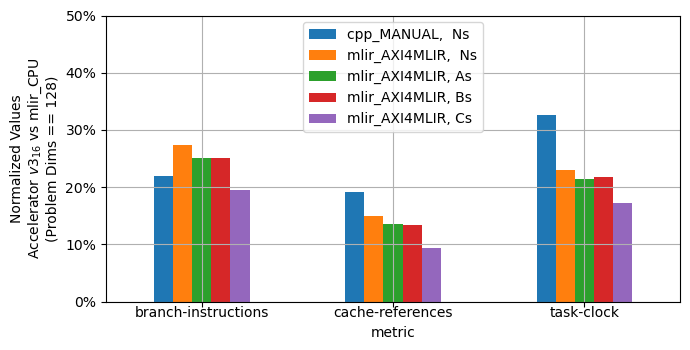

In [112]:
# Edit the following variables to change the plot

experiment = 'plot-manual-vs-mlir-flows-128-16-counters-limited'
logy = False
y_label = 'Normalized Values\nAccelerator $v3_{16}$ vs mlir_CPU\n(Problem Dims == 128)'
x_label_rotation = True
title = ''
figure_size = (7, 3.6)


# What to plot
to_plot = ['value']
# pv_columns = ['strategy', 'tool']
pv_columns = ['tool', 'strategy']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
# filter_dict['metric'] = 'task-clock'
filter_dict['accel_version'] = 'v3'
filter_dict['dims'] = 128
filter_dict['accel_size'] = 16

filtered_df = filter_df(df_n2, filter_dict)

# only include the following tools metrics

# options: ['branch-instructions', 'branch-misses', 'cache-references',
#    'cache-misses', 'cpu-cycles', 'context-switches', 'page-faults',
#    'task-clock', 'L1-dcache-load-misses', 'L1-dcache-loads',
#    'L1-dcache-stores', 'L1-icache-load-misses', 'duration_time']

# keep task-clock, l1-dcache-loads, l1-dcache-stores,cache-references,cache-misses
filtered_df = filtered_df[filtered_df.metric.isin(
    ['task-clock', 'cache-references', 'branch-instructions'])]


# remove mlir_CPU
filtered_df = filtered_df[filtered_df.tool != 'mlir_CPU']

# remove v1
filtered_df = filtered_df[filtered_df.accel_version != 'v1']

# # filter, accept accel_size different than 4
# filtered_df = filtered_df[filtered_df.accel_size != 4]

# # filter any dims simaller than 64
# filtered_df = filtered_df[filtered_df.dims >= 64]

# filter out tool cpp_MAN that is not strategy Ns
positive_filter = (filtered_df['tool'] == 'cpp_MAN') & (
    filtered_df['strategy'] != 'Ns')
filtered_df = filtered_df[~positive_filter]

# rename all strategy Ns to ' Ns'
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'Ns': ' Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=figure_size, logy=logy)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
# ax.set_yticks([10000, 100000])

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
# y ticks
# add grid
ax.grid()
print('filter_dict: {}'.format(filter_dict))
plt.title(title)
plt.ylabel(y_label)
# Limit y axis to 0.0 to 0.5
plt.ylim(0.0, 0.5)
# Transform axis to percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# legend to top middle
handles, labels = update_legend_labels(ax)
ax.legend(handles, labels, loc='upper center')

if (x_label_rotation):
    plt.xticks(rotation=0, ha='center')
if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


## Overall task clock result for optimized version

pv_index:	['dims', 'kernel', 'accel_size', 'accel_version', 'strategy', 'board', 'metric']
pv_columns:	['tool']
to_plot:	['value']
len of df_pivot: 42
dropping kernel          unique value is: Index(['matmul_i32'], dtype='object', name='kernel') 
dropping board           unique value is: Index(['tul_rel'], dtype='object', name='board') 
dropping metric          unique value is: Index(['task-clock'], dtype='object', name='metric') 
filter_dict: {'metric': 'task-clock'}


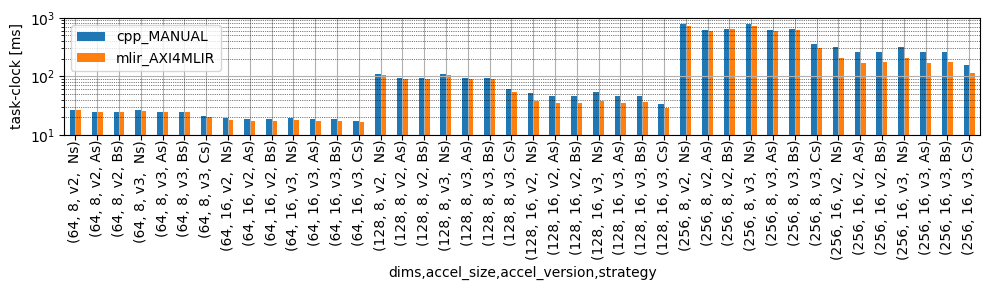

In [113]:
# Edit the following variables to change the plot

experiment = 'plot-manual-vs-mlir-genereated-all-ns-vs-all-logscale'
logy = True
y_label = 'task-clock [ms]'
x_label_rotation = False
title = ''
figure_size = (10, 3)

# What to plot
# to_plot = ['value']
pv_columns = ['strategy', 'tool']
pv_columns = ['tool', 'strategy']
# pv_columns = ['strategy']
pv_columns = ['tool']
# pv_columns = ['accel_version']

# ==============================================================================

figure_name = 'outputs/{}{}.{}'.format(experiment, path_suffix, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)

filter_dict = {}
filter_dict['metric'] = 'task-clock'
# filter_dict['dims'] = 128

filtered_df = filter_df(df, filter_dict)

# remove mlir_CPU
filtered_df = filtered_df[filtered_df.tool != 'mlir_CPU']

# remove v1
filtered_df = filtered_df[filtered_df.accel_version != 'v1']

# filter, accept accel_size different than 4
filtered_df = filtered_df[filtered_df.accel_size != 4]

# filter any dims simaller than 64
filtered_df = filtered_df[filtered_df.dims >= 64]

# filter out tool cpp_MAN that is not strategy Ns
# positive_filter = (filtered_df['tool'] == 'cpp_MAN') & (
#     filtered_df['strategy'] != 'Ns')
# filtered_df = filtered_df[~positive_filter]

# rename all strategy Ns to ' Ns'
filtered_df['strategy'] = filtered_df['strategy'].replace(
    {'Ns': ' Ns'})


# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]

print('pv_index:\t{}'.format(pv_index))
print('pv_columns:\t{}'.format(pv_columns))
print('to_plot:\t{}'.format(to_plot))

# make a pivot table
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
print('len of df_pivot: {}'.format(len(df_pivot)))

df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        # print with specic number of characters for first value
        print('dropping {:<15} unique value is: {} '.format(
            col, df_dropped.index.get_level_values(col).unique()))
        df_dropped = df_dropped.droplevel(col)

# save as df_to_plot
df_to_plot = df_dropped

# plotting with pandas
# plot log scale
ax = df_to_plot.plot(kind='bar', figsize=figure_size, logy=logy)
# ax.set_yticks([1, 10, 100, 1000, 10000, 100000])
ax.set_yticks([10, 100, 1000])

# ax = df_to_plot.plot(kind='bar', figsize=(10, 5))
update_legend_labels(ax)
# y ticks
# add grid
ax.grid()
# add internal grid lines
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
print('filter_dict: {}'.format(filter_dict))
# remove x ticks labels
# plt.xticks([])
plt.title(title)
plt.ylabel(y_label)
if (x_label_rotation):
    # ax.set_xticklabels(labels=ax.get_xticklabels(),
    #                       rotation=90,
    #  ha='right', x=100) # move the labels to the left
    plt.xticks(rotation=55, ha='right')

if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()


## Aggregated Metrics

### Speedup

In [114]:

# Calculate speedup for each pair of tool and strategy
# creating a new dataframe with the speedup
metric = 'task-clock'
df_interest = df[df['metric'] == metric]
df_interest = df_interest[df_interest['tool'] != 'mlir_CPU']

# filter out 32 or below and acc4
df_interest = df_interest[df_interest['accel_size'] != 4]
df_interest = df_interest[df_interest['dims'] >= 64]
df_interest = df_interest.drop(columns=['metric'])

# make a pivot table on tool
index = ['accel_version', 'accel_size', 'dims', 'strategy']
columns = ['tool']
values = ['value']
df_pivot = df_interest.pivot_table(
    index=index, columns=columns, values=values)


speedups = df_pivot[('value', 'cpp_MAN')]/df_pivot[('value', 'mlir_ACC')]
np_speedups = speedups.to_numpy()
np_dimensions = df_pivot[('value', 'cpp_MAN')].reset_index()['dims'].to_numpy()
np_accelsize = df_pivot[('value', 'cpp_MAN')].reset_index()[
    'accel_size'].to_numpy()

np_operations = (np_dimensions**3)*2  # 2 M N K
np_accelsize = np_accelsize**2  # 1 squared tile worth of data per run

geomean = np.exp(np.mean(np.log(np_speedups)))
max_speedup = np.max(np_speedups)
avg_speedup = np.mean(np_speedups)
weighted_avg_ops_speedup = np.average(np_speedups, weights=np_operations)
weighted_avg_accelsize_speedup = np.average(np_speedups, weights=np_accelsize)

# Same as above but format for 2 decimal places
print('avg speedup: {:.2f}'.format(avg_speedup))
print('max speedup: {:.2f}'.format(max_speedup))
print('geomean: {:.2f}'.format(geomean))
print('weighted avg ops speedup: {:.2f}'.format(weighted_avg_ops_speedup))
print('weighted avg accelsize speedup: {:.2f}'.format(
    weighted_avg_accelsize_speedup))


avg speedup: 1.19
max speedup: 1.65
geomean: 1.18
weighted avg ops speedup: 1.30
weighted avg accelsize speedup: 1.26


### Ratios

In [115]:
metrics = [
    'task-clock',
    # 'branch-instructions',
    # 'branch-misses',
    'cache-references',
    # 'cache-misses',
    # 'cpu-cycles',
    # 'context-switches',
    # 'page-faults',
    # 'L1-dcache-load-misses',
    'L1-dcache-loads',
    'L1-dcache-stores',
    # 'L1-icache-load-misses',
    # 'duration_time'
]
for metric in metrics:
    df_interest = df[df['metric'] == metric]
    df_interest = df_interest[df_interest['tool'] != 'mlir_CPU']

    # filter out 32 or below and acc4
    df_interest = df_interest[df_interest['accel_size'] != 4]
    df_interest = df_interest[df_interest['dims'] >= 64]
    df_interest = df_interest.drop(columns=['metric'])

    # make a pivot table on tool
    index = ['accel_version', 'accel_size', 'dims', 'strategy']
    columns = ['tool']
    values = ['value']
    df_pivot = df_interest.pivot_table(
        index=index, columns=columns, values=values)

    ratio = df_pivot[('value', 'mlir_ACC')]/df_pivot[('value', 'cpp_MAN')]
    np_ratio = ratio.to_numpy()
    np_dimensions = df_pivot[('value', 'cpp_MAN')].reset_index()[
        'dims'].to_numpy()
    np_accelsize = df_pivot[('value', 'cpp_MAN')].reset_index()[
        'accel_size'].to_numpy()

    np_operations = (np_dimensions**3)*2  # 2 M N K
    np_elements = ((np_dimensions*2)*4)  # load A, B, C, Store C
    np_accelsize = np_accelsize**2  # 1 squared tile worth of data per run

    geomean = np.exp(np.mean(np.log(np_ratio)))
    max_ratio = np.max(np_ratio)
    min_ratio = np.min(np_ratio)
    avg_ratio = np.mean(np_ratio)
    weighted_avg_ops_ratio = np.average(np_ratio, weights=np_operations)
    weighted_avg_accelsize_ratio = np.average(np_ratio, weights=np_accelsize)

    if (avg_ratio < 1):

        # Same as above but format for 2 decimal places
        print('metric: {}'.format(metric))
        print('avg ratio: {:.2f}'.format(avg_ratio))
        print('min ratio: {:.2f}'.format(min_ratio))
        # print('max ratio: {}'.format(max_ratio))
        print('geomean: {:.2f}'.format(geomean))
        print('weighted avg ops ratio: {:.2f}'.format(weighted_avg_ops_ratio))
        print('weighted avg accelsize ratio: {:.2f}'.format(
            weighted_avg_accelsize_ratio))
        print('weighted avg elements ratio: {:.2f}'.format(
            np.average(np_ratio, weights=np_elements)))
        print('')


metric: task-clock
avg ratio: 0.86
min ratio: 0.60
geomean: 0.85
weighted avg ops ratio: 0.80
weighted avg accelsize ratio: 0.81
weighted avg elements ratio: 0.83

metric: cache-references
avg ratio: 0.91
min ratio: 0.44
geomean: 0.90
weighted avg ops ratio: 0.88
weighted avg accelsize ratio: 0.86
weighted avg elements ratio: 0.89

metric: L1-dcache-loads
avg ratio: 0.92
min ratio: 0.42
geomean: 0.90
weighted avg ops ratio: 0.88
weighted avg accelsize ratio: 0.86
weighted avg elements ratio: 0.90

metric: L1-dcache-stores
avg ratio: 0.92
min ratio: 0.42
geomean: 0.91
weighted avg ops ratio: 0.88
weighted avg accelsize ratio: 0.87
weighted avg elements ratio: 0.90



# Working with normalized data

In [116]:
# pivot metric values into columns
# all_columns = ['problem_size', 'dims', 'kernel', 'tool', 'accel_size', 'accel_version',
#                'strategy', 'threads', 'board', 'value', 'metric']
all_columns = df.columns
columns_to_pivot = ['metric']
values_to_pivot = ['value']
# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in columns_to_pivot + values_to_pivot]
df_p = df.pivot(index=pv_index, columns=columns_to_pivot,
                values=values_to_pivot[0])
df_p = df_p.reset_index()
df_p.head()


metric,dims,kernel,tool,accel_size,accel_version,strategy,board,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,branch-instructions,branch-misses,cache-misses,cache-references,context-switches,cpu-cycles,duration_time,page-faults,task-clock
0,16,matmul_i32,cpp_MAN,4,v1,Ns,tul_rel,47787.0,1895116.0,1983630.0,163145.0,504136.0,134095.0,47787.0,1895116.0,1.0,9989951.0,16544708.0,112.0,15.49
1,16,matmul_i32,cpp_MAN,4,v2,As,tul_rel,48334.0,1881238.0,2093064.0,NaN,502681.0,126587.0,48334.0,1881238.0,1.0,9862591.0,16350710.0,110.0,15.26
2,16,matmul_i32,cpp_MAN,4,v2,Bs,tul_rel,46288.0,1881620.0,1975667.0,141917.0,496643.0,133360.0,46288.0,1881620.0,1.0,9891297.0,16413394.0,110.0,15.34
3,16,matmul_i32,cpp_MAN,4,v2,Ns,tul_rel,45516.0,1878675.0,2033632.0,NaN,505887.0,125842.0,45516.0,1878675.0,0.0,9774689.0,16004509.0,111.0,15.11
4,16,matmul_i32,cpp_MAN,4,v3,As,tul_rel,46150.0,1878021.0,1791512.0,NaN,546239.0,126595.0,46150.0,1878021.0,1.0,9860392.0,16467102.0,111.0,15.25


In [117]:
# Prepare for normalization
all_columns = df.columns
columns_to_pivot = ['metric']
values_to_pivot = ['value']
# make pv_index the remaining column names not in pv_columns and to_plot
pv_index = [x for x in all_columns if x not in columns_to_pivot + values_to_pivot]
df_p = df.pivot(index=pv_index, columns=columns_to_pivot,
                values=values_to_pivot[0])
df_p = df_p.reset_index()

# Normalize all values based on row mlir_CPU, accel_size=0, accel_version=NONE, strategy=NONE, dims=<dims_value>
# columns to normalize: c
c = df['metric'].unique()

for d in df_p['dims'].unique():
    cpu_loc = (df_p['tool'] == 'mlir_CPU') & (df_p['dims'] == d)
    acc_loc = (df_p['tool'] == 'mlir_ACC') & (df_p['dims'] == d)
    man_loc = (df_p['tool'] == 'cpp_MAN') & (df_p['dims'] == d)

    # assert count of True values in cpu_loc is 1
    assert sum(cpu_loc) == 1

    # Normalize accelerator values by CPU values, then normalize CPU values by CPU values
    df_p.loc[acc_loc, c] = df_p.loc[acc_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[man_loc, c] = df_p.loc[man_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)
    df_p.loc[cpu_loc, c] = df_p.loc[cpu_loc, c].apply(
        lambda x: x / df_p.loc[cpu_loc, c].values[0], axis=1)

df_n = df_p
df_n.head()


metric,dims,kernel,tool,accel_size,accel_version,strategy,board,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,branch-instructions,branch-misses,cache-misses,cache-references,context-switches,cpu-cycles,duration_time,page-faults,task-clock
0,16,matmul_i32,cpp_MAN,4,v1,Ns,tul_rel,1.063659,1.023306,0.914841,NaN,1.088301,1.097754,1.063659,1.023306,inf,1.070834,1.081027,1.037037,1.073458
1,16,matmul_i32,cpp_MAN,4,v2,As,tul_rel,1.075834,1.015812,0.965311,NaN,1.085160,1.036290,1.075834,1.015812,inf,1.057183,1.068351,1.018519,1.057519
2,16,matmul_i32,cpp_MAN,4,v2,Bs,tul_rel,1.030294,1.016019,0.911168,NaN,1.072126,1.091737,1.030294,1.016019,inf,1.060260,1.072447,1.018519,1.063063
3,16,matmul_i32,cpp_MAN,4,v2,Ns,tul_rel,1.013110,1.014429,0.937901,NaN,1.092081,1.030191,1.013110,1.014429,NaN,1.047760,1.045730,1.027778,1.047124
4,16,matmul_i32,cpp_MAN,4,v3,As,tul_rel,1.027222,1.014075,0.826237,NaN,1.179191,1.036356,1.027222,1.014075,inf,1.056947,1.075956,1.027778,1.056826


In [118]:
df_dropped = df_n

# keep_c = ['problem_size', 'dims', 'kernel', 'tool', 'accel_size',
#           'accel_version', 'strategy', 'threads', 'board']
keep_c = ['dims', 'kernel', 'tool', 'accel_size',
          'accel_version', 'strategy', 'board']
keep_cm = c

# drop_c = ['problem_size', 'kernel', 'threads', 'board']
drop_c = ['kernel', 'board']
drop_cm = ['L1-icache-load-misses', 'duration_time', 'context-switches']
keep_c = [x for x in keep_c if x not in drop_c]
keep_cm = [x for x in keep_cm if x not in drop_cm]

print(keep_c)
print(keep_cm)

# First drop values that are not relevant:
df_dropped = df_dropped.drop(columns=drop_c, inplace=False)
df_dropped = df_dropped.drop(columns=drop_cm, inplace=False)

# Some filters
df_dropped = df_dropped[df_dropped['dims'] >= 64]
df_dropped = df_dropped[df_dropped['accel_size'] != 4]
# df_dropped = df_dropped[df_dropped['tool'] != 'mlir_ACC']
# df_dropped = df_dropped[df_dropped['tool'] != 'cpp_MAN']
df_dropped = df_dropped[(df_dropped['strategy'] == 'Ns')
                        | (df_dropped['strategy'] == 'NONE')]

# Transform values under c columns into two columns: metric and value
df_dropped = df_dropped.melt(
    id_vars=keep_c, value_vars=keep_cm, var_name='metric', value_name='value')


print(df_dropped.shape)
df_dropped.head()


['dims', 'tool', 'accel_size', 'accel_version', 'strategy']
['branch-instructions', 'branch-misses', 'cache-references', 'cache-misses', 'cpu-cycles', 'page-faults', 'task-clock', 'L1-dcache-load-misses', 'L1-dcache-loads', 'L1-dcache-stores']
(390, 7)


,dims,tool,accel_size,accel_version,strategy,metric,value
0,64,cpp_MAN,8,v1,Ns,branch-instructions,0.564780
1,64,cpp_MAN,8,v2,Ns,branch-instructions,0.812982
2,64,cpp_MAN,8,v3,Ns,branch-instructions,0.703838
3,64,cpp_MAN,16,v1,Ns,branch-instructions,0.574262
4,64,cpp_MAN,16,v2,Ns,branch-instructions,0.584516


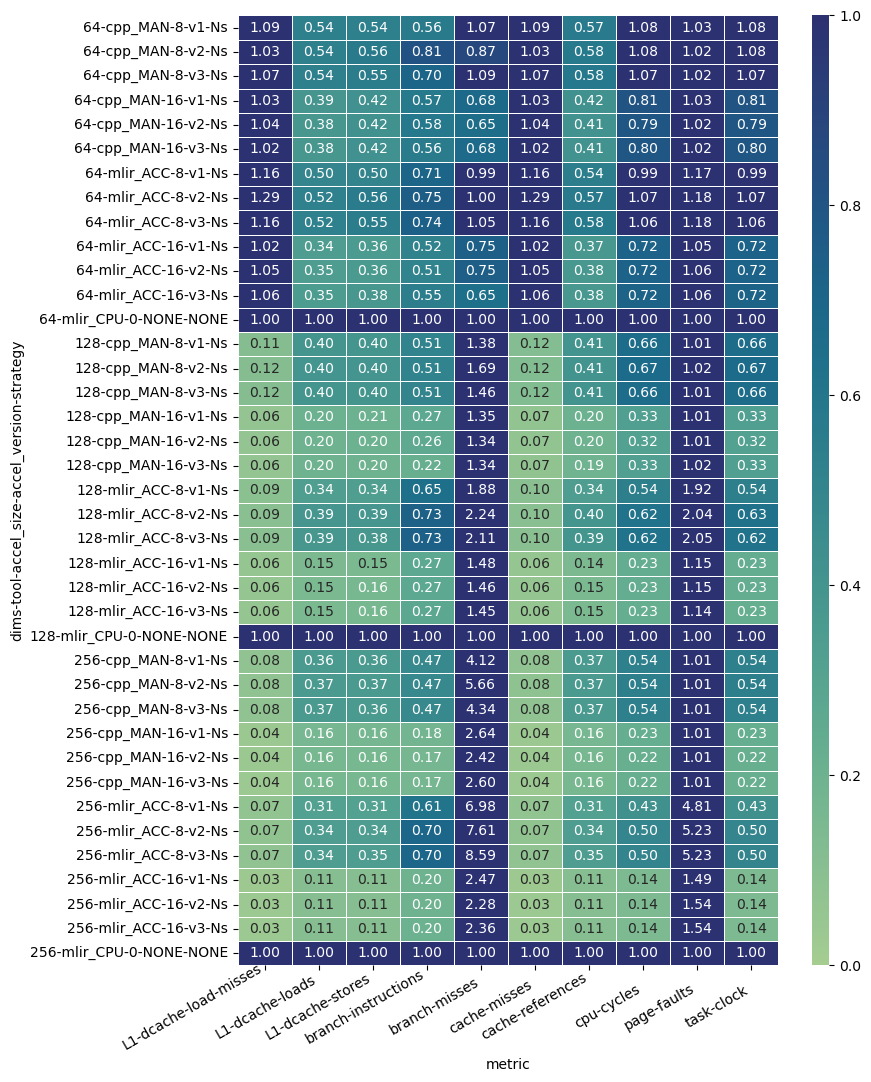

In [119]:
# use seaborn to plot the heatmap of the normalized values presented in columns c
yv = 1250
xv = 6
ys, xs = df_dropped.shape
# fix legend
legend_cfg = {}
# legend_cfg["shrink"] = 0.2 # default is 0.2
legend_cfg["aspect"] = 175*ys/yv  # default is 20
# legend_cfg["fraction"] = 1 # default is 0.2

df_pivot = df_dropped.pivot(index=keep_c, columns='metric', values='value')
plt.figure(figsize=(8*xs/xv, 35*ys/yv))
ax = sns.heatmap(df_pivot,
                 linewidth=.5, annot=True, fmt='.2f',
                 vmin=0, vmax=1,
                 cmap="crest",
                 cbar_kws=legend_cfg
                 )
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
# rotate xticks
plt.xticks(rotation=30, va='center', ha='right', position=(0, -0.012*yv/ys))
# tight layout
plt.tight_layout()
